# General pipeline for project 1
This is an example pipeline showing you how to  
(1) Load the provided data;  
(2) Train models on the train set, and use the validation set to evaluate your model performance;  
(3) Generate predictions (pred.csv) on the test set, which is ready for submission.

In [60]:
import os
import nltk
import math
import pandas as pd
import numpy as np
# import keras
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, BatchNormalization, Activation, Input, \
#    Conv1D, MaxPool1D, Flatten, Concatenate, Add
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Dropout, BatchNormalization, Activation, Input, \
    Conv1D, MaxPool1D, Flatten, Concatenate, Add
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import tqdm

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

In [ ]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [4]:
# if you use Google Colab, un-comment this cell, modify `path_to_data` if needed, and run to mount data to `data`
# from google.colab import drive
# drive.mount('/content/drive')

# path_to_data = '/content/drive/MyDrive/HKUST stuff/COMP4332_Project1/data'
# !rm -f data
# !ln -s '/content/drive/MyDrive/HKUST stuff/COMP4332_Project1/data' data

### (1) Loading data
The following code shows how to load the datasets for this project.  
Among which, we do not release the labels (the "stars" column) for the test set. You may evaluate your trained model on the validation set instead.

However, your submitted predictions (``pred.csv``) should be generated on the test set.

In [5]:
def load_data(split_name='train', columns=['text', 'stars'], folder='data'):
    '''
        "split_name" may be set as 'train', 'valid' or 'test' to load the corresponding dataset.
        
        You may also specify the column names to load any columns in the .csv data file.
        Among many, "text" can be used as model input, and "stars" column is the labels (sentiment). 
        If you like, you are free to use columns other than "text" for prediction.
    '''
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        df = df.loc[:,columns]
        print("Success")
        return df
    except:
        print(f"Failed loading specified columns... Returning all columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        return df

In [6]:
train_df = load_data('train', columns=['text', 'stars'])
valid_df = load_data('valid', columns=['text', 'stars'])
# the test set labels (the 'stars' column) are not available! So the following code will instead return all columns
test_df = load_data('test', columns=['text', 'stars'])

select [text, stars] columns from the train split
Success
select [text, stars] columns from the valid split
Success
select [text, stars] columns from the test split
Failed loading specified columns... Returning all columns from the test split


In [29]:
# test_df.columns
# print(train_df.columns)
# print(valid_df.columns)
# print(test_df.columns)
# test_df

Processing

<!-- 2.Processing -->

In [21]:
stopwords = set(stopwords.words('english'))
ps = PorterStemmer()

def lower(s):
    """
    :param s: a string.
    return a string with lower characters
    Note that we allow the input to be nested string of a list.
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: 'text mining is to identify useful information.'
    """
    if isinstance(s, list):
        return [lower(t) for t in s]
    if isinstance(s, str):
        return s.lower()
    else:
        raise NotImplementedError("unknown datatype")


def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)


def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]

def n_gram(tokens, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results

def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]


In [22]:
def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    # .most_common(): List the n most common elements and their counts from the most common to the least.
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = ["<pad>", "<unk>"] + [f for f, cnt in feat_cnt.most_common(max_size-2)]
    else:
        valid_feats = ["<pad>", "<unk>"]
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_index_vector(feats, feats_dict, max_len):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        try:
            vector[i] = feats_dict[f]
        except KeyError:
            vector[i] = 1
    return vector

In [15]:
test_df['tokens'] = test_df['text'].map(tokenize).map(filter_stopwords).map(lower)
print(test_df['tokens'].head().to_string())

0    [would, like, give, stars, -, usually, i, get,...
1    [my, wife, i, took, friends, dinner, advise, a...
2    [my, husband, i, lunch, first, time, years, .,...
3    [i, love, coming, friends, !, great, groups, o...
4    [make, sure, double, check, much, guys, chargi...


In [25]:
# import spacy
# nlp = spacy.load('en_core_web_sm')

In [26]:

# fmt = "{:10s},\t " * 8
# print(fmt.format('raw', 'stem', 'PartOfSpeech', 'dependency', 'shape', 'is alpha', 'is stop', 'its childrens in the parsing tree'))
# print('-'*140)
# for token in doc:
#     print(fmt.format(token.text, token.lemma_, token.pos_, token.dep_,
#             token.shape_, str(token.is_alpha), str(token.is_stop), str(list(token.children))))

Classifier: Convolutional Neural Network

In [36]:
def build_CNN(input_length, vocab_size, embedding_size,
              hidden_size, output_size,
              kernel_sizes, num_filters, num_mlp_layers,
              padding="valid",
              strides=1,
              activation="relu",
              dropout_rate=0.0,
              batch_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="SGD",
              learning_rate=0.1,
              metric="accuracy"):
    
    x = Input(shape=(input_length,))
    
    ################################
    ###### Word Representation #####
    ################################
    # word representation layer
    emb = Embedding(input_dim=vocab_size, output_dim=embedding_size)(x)
    
    ################################
    ########### Conv-Pool ##########
    ################################
    # convolutional and pooling layers
    cnn_results = list()
    for kernel_size in kernel_sizes:
        # add convolutional layer
        conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding=padding, strides=strides)(emb)
        # add batch normalization layer
        if batch_norm:
            conv = BatchNormalization()(conv)
        # add activation
        conv = Activation(activation)(conv)
        # add max-pooling
        maxpool = MaxPool1D(pool_size=(input_length-kernel_size)//strides+1)(conv)
        cnn_results.append(Flatten()(maxpool))
    
    ################################
    ##### Fully Connected Layer ####
    ################################
    h = Concatenate()(cnn_results) if len(kernel_sizes) > 1 else cnn_results[0]
    h = Dropout(dropout_rate, seed=0)(h)
    # multi-layer perceptron
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.he_normal(seed=0),
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        # add batch normalization layer
        if batch_norm:
            new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        # add activation
        h = Activation(activation)(h)
    y = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

### (2) Training and validating 
The following example shows you how to train your model using the train set, and evaluate on the validation set.  
As an example, we only use the text data for training. Feel free to use other columns in your implementation.  

The model performance on the validation set can be roughly regarded as your models final performance, so we can use it to search for optimal hyper-parameters.

In [30]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import tqdm

In [10]:
# Prepare the data.
# As an example, we only use the text data. 
x_train = train_df['text']
y_train = train_df['stars']
  
x_valid = valid_df['text']
y_valid = valid_df['stars']

x_test = test_df['text']

In [34]:
train_feats = x_train.map(tokenize).map(filter_stopwords).map(stem)
valid_feats = x_valid.map(tokenize).map(filter_stopwords).map(stem)

In [38]:
min_freq = 3
feats_dict = get_feats_dict(
    chain.from_iterable(train_feats),
    min_freq=min_freq)

Size of features: 11891


In [63]:
max_len = 100

# build the feats_matrix
# convert each example to a index vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in train_feats])
valid_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in valid_feats])

# convert labels to label_matrix
num_classes = max(y_train)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(y_train-1, num_classes=num_classes)
valid_label_matrix = keras.utils.to_categorical(y_valid-1, num_classes=num_classes)

In [64]:
os.makedirs("models", exist_ok=True)

# TODO: use build_CNN() to call the model
model = build_CNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  kernel_sizes=[1,2,3,4], num_filters=100, num_mlp_layers=3,
                  activation="relu")
# model.summary()

checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

np.random.seed(0)
tf.random.set_seed(0)
cnn_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer])
#model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

# train_score = model.evaluate(train_feats_matrix, train_label_matrix,
#                              batch_size=100)
# valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
#                             batch_size=100)
# print("training loss:", train_score[0], "training accuracy", train_score[1])
# print("valid loss:", valid_score[0], "test accuracy", valid_score[1])


20/20 [==============================] - 0s 10ms/step - loss: 2.5214 - accuracy: 0.6170
training loss: 0.2766949534416199 training accuracy 0.9594444632530212
valid loss: 2.5213520526885986 test accuracy 0.6169999837875366


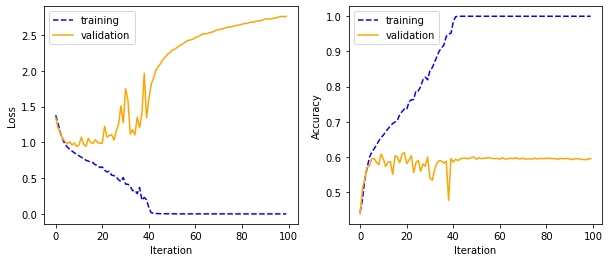

In [65]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(cnn_history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(cnn_history.history["val_loss"], label="validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(cnn_history.history["accuracy"], label="training", color="blue", linestyle="dashed")
plt.plot(cnn_history.history["val_accuracy"], label="validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [69]:
y_pred = model.predict(valid_feats_matrix)

63/63 [==============================] - 1s 5ms/step


In [71]:
y_pred

array([[1.0398727e-12, 2.8283699e-13, 2.1908716e-12, 7.9390663e-09,
        1.0000000e+00],
       [3.0512176e-06, 3.7850288e-07, 1.7795319e-06, 2.8295782e-01,
        7.1703696e-01],
       [9.9825186e-01, 1.7475452e-03, 5.7427974e-07, 4.0472473e-10,
        3.1381813e-08],
       ...,
       [7.0170161e-14, 2.4682518e-13, 3.2562906e-13, 9.1308925e-09,
        1.0000000e+00],
       [9.9754494e-01, 2.3209024e-03, 1.2922555e-04, 3.4346212e-07,
        4.5395036e-06],
       [8.2474202e-13, 8.7998270e-15, 6.7699589e-14, 1.2954374e-07,
        9.9999988e-01]], dtype=float32)

In [72]:
y_valid

0       5
1       5
2       2
3       3
4       1
       ..
1995    5
1996    3
1997    5
1998    1
1999    5
Name: stars, Length: 2000, dtype: int64

In [74]:
print(classification_report(valid_label_matrix, y_pred))
print("\n\n")
print(confusion_matrix(valid_label_matrix, y_pred))
print('accuracy', np.mean(valid_label_matrix == y_pred))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

 You can use the valid data to choose the hyperparameters.
As an example, you can decide which value of C (1 or 100) is better by evaluating on the valid data.

In [54]:
model = build_CNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  kernel_sizes=[1,2,3,4], num_filters=100, num_mlp_layers=3,
                  activation="relu")
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
np.random.seed(0)
tf.random.set_seed(0)

In [59]:
# build the first linear model with TFIDF feature
tfidf = TfidfVectorizer()
lr1 = LogisticRegression(C=100)
steps = [('tfidf', tfidf), 
         ('CNN', model.fit(train_feats_matrix, train_label_matrix,
                           validation_split=0.1,
                           epochs=100, batch_size=100, verbose=0,
                           callbacks=[checkpointer])),
          ('lr', lr1)]
pipe1 = Pipeline(steps)

TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' '<keras.callbacks.History object at 0x7fd636014be0>' (type <class 'keras.callbacks.History'>) doesn't

In [53]:
# train the first model
pipe1.fit(x_train, y_train)

ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'scipy.sparse.csr.csr_matrix'>]

In [9]:
# validate on the validation set
y_pred = pipe1.predict(x_valid)
print(classification_report(y_valid, y_pred))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

              precision    recall  f1-score   support

           1       0.73      0.80      0.76       292
           2       0.39      0.29      0.34       163
           3       0.35      0.36      0.36       232
           4       0.43      0.44      0.43       421
           5       0.78      0.78      0.78       892

    accuracy                           0.62      2000
   macro avg       0.54      0.53      0.53      2000
weighted avg       0.62      0.62      0.62      2000




[[233  30  15   6   8]
 [ 48  48  50  10   7]
 [ 22  28  83  71  28]
 [  6  10  71 184 150]
 [ 10   6  16 161 699]]
accuracy 0.6235


In [10]:
# build the second linear model with TFIDF feature
tfidf = TfidfVectorizer()
CNN = 
lr2 = LogisticRegression(C=1)
steps = [('tfidf', tfidf),('lr', lr2)]
pipe2 = Pipeline(steps)

In [11]:
# train the second model
pipe2.fit(x_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('lr', LogisticRegression(C=1))])

In [12]:
# validate on the validation set
y_pred = pipe2.predict(x_valid)
print(classification_report(y_valid, y_pred))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

              precision    recall  f1-score   support

           1       0.70      0.84      0.76       292
           2       0.47      0.17      0.25       163
           3       0.45      0.27      0.34       232
           4       0.48      0.48      0.48       421
           5       0.75      0.87      0.81       892

    accuracy                           0.66      2000
   macro avg       0.57      0.53      0.53      2000
weighted avg       0.63      0.66      0.63      2000




[[245  16   6   7  18]
 [ 65  28  39  19  12]
 [ 24  14  63  87  44]
 [  9   1  28 202 181]
 [  7   1   5 104 775]]
accuracy 0.6565


 We find the second model (pipe2) has higher accuracy, then we use the second model to make predictions on test data. In practice, you may not only focus on the accuracy, but also other metrics (precision, recall, f1), since the label distribution is not always balanced.

### (3) Generate predictions on the test set

In [13]:
predict_test = pipe2.predict(x_test)

In [14]:
predict_test

array([3, 4, 5, ..., 1, 5, 1])

In [15]:
# save your model predictions
pred_df = pd.DataFrame({'stars': predict_test, 'review_id': test_df['review_id']})
pred_df.to_csv('pred.csv', index=False)

 Then you may (download and) submit the predictions `pred.csv` on the test set. 